In [1]:
# Import modules, define directories

from bokeh.plotting import figure 
import pandas as pd
from scipy.stats import spearmanr
from pyhere import here
from scipy.stats import rankdata
import geopandas as gpd
from matplotlib.colors import ListedColormap    
import matplotlib.pyplot as plt
# import os
# import sys
%run 'spss_pca.ipynb'

path = {
    "dscr": here("data", "scratch"),
    "drpub": here("data", "raw", "public"),
    "drpriv": here("data", "raw", "private"),
    "ddpub": here("data", "derived", "public"),
    "ddpriv": here("data", "derived", "private"),
    "rfig": here("results", "figures"),
    "roth": here("results", "other"),
    "rtab": here("results", "tables")
}

## Figure 2

I can't find any code to create this figure in their repo. There is definitely some code to process the data though.

Note: the input to making this figure matched in both my results and their provided data. But if I need to be doing something with dropping observations, I have not done that.

In [2]:
input_names = [['MEDAGE_ACS', 'pos', 'person', 'Median Age'],
               ['BLACK_ACS', 'pos', 'person', 'Pop African-American (%)'],
               ['QNATAM_ACS', 'pos', 'person', 'Pop Native American (%)'],
               ['QASIAN_ACS', 'pos', 'person', 'Pop Asian (%)'],
               ['QHISP_ACS', 'pos', 'person', 'Pop Hispanic (%)'],
               ['QAGEDEP_ACS', 'pos', 'person', 'Age Dependency (%)'],
               ['QPUNIT_ACS', 'pos', 'person', 'Persons Per Housing Unit'],
               ['PRENTER_ACS', 'pos', 'hu', 'Rental Housing (%)'],
               ['QNRRES_ACS', 'pos', 'person', 'Nursing Home Residents (%)'],
               ['QFEMALE_ACS', 'pos', 'person', 'Pop Female (%)'],
               ['QFHH_ACS', 'pos', 'hu', 'Female-Headed Households (%)'],
               ['QUNOCCHU_ACS', 'pos', 'hu', 'Vacant Housing (%)'],
               ['PERCAP_ALT', 'neg', 'person', 'Per-Capita Income'],
               ['QESL_ALT', 'pos', 'person', 'English as Second Language (%)'],
               ['QCVLUN', 'pos', 'person', 'Unemployment (%)'],
               ['QPOVTY', 'pos', 'person', 'Poverty (%)'],
               ['QMOHO', 'pos', 'hu', 'Mobile Homes (%)'],
               ['QED12LES_ALT', 'pos', 'person',
                   'Adults Completed <Grade 12 (%)'],
               ['QFEMLBR', 'pos', 'person', 'Female Employment (%)'],
               ['QEXTRCT_ALT', 'pos', 'person',
                   'Extractive Sector Employment (%)'],
               ['QSERV_ALT', 'pos', 'person', 'Service Sector Employment (%)'],
               ['QSSBEN', 'pos', 'hu', 'Social Security Income (%)'],
               ['QNOAUTO_ALT', 'pos', 'hu', 'No Automobile (%)'],
               ['QFAM', 'neg', 'person', 'Children in Married Families (%)'],
               ['QRICH200K', 'neg', 'hu', 'Annual Income >$200K (%)'],
               ['MDGRENT_ALT', 'neg', 'hu', 'Median Rent'],
               ['MHSEVAL_ALT', 'neg', 'hu', 'Median Home Value'],
               ['POPDENS', 'pos', 'person', 'Population Density']]

# attr_names = [j[0] for j in input_names] + ['GEOID']

In [3]:
varContrib = pd.read_csv( here(path["ddpub"], "variable_contributions.csv") )

varContrib.index = varContrib["Unnamed: 0"]
varContrib = varContrib.drop(columns = ["Unnamed: 0"])

In [4]:
# Determine all reversals from expected sign
reversals = varContrib.copy()
for i in range(len(varContrib.index)):
    # Iterate over the variables
    if varContrib.index[i] != input_names[i][0]:
        print("ERROR")
        break
    else:
        # Iterate over the different SoVI runs
        for j in range(len(varContrib.columns)):
            if input_names[i][1] == "pos" and varContrib.iloc[i, j] > 0:
                reversals.iloc[i, j] = 0
            elif input_names[i][1] == "neg" and varContrib.iloc[i, j] > 0:
                reversals.iloc[i, j] = 1
            elif input_names[i][1] == "neg" and varContrib.iloc[i, j] < 0:
                reversals.iloc[i, j] = 0
            elif input_names[i][1] == "pos" and varContrib.iloc[i, j] < 0:
                reversals.iloc[i, j] = 1
            else:
                print("WATCH OUT THERE'S A ZERO BRO")

In [5]:
rankContrib = abs(varContrib).apply(rankdata, axis=0, method='average')
rankContrib = (28-rankContrib) + 1

In [6]:
rankContrib = rankContrib.sort_values("USA", ascending = True).reset_index()
rankContrib.index = rankContrib["Unnamed: 0"]
rankContrib = rankContrib.drop(columns = ["Unnamed: 0"])

In [7]:
summary_stats = pd.DataFrame( {"min": rankContrib.min(axis = 1),
                               "max": rankContrib.max(axis = 1),
                               "range": rankContrib.max(axis = 1) - rankContrib.min(axis = 1),
                               "avg": rankContrib.mean(axis = 1)
                              } )

In [8]:
def pos_neg(x):
    if x > 0:
        return "pos"
    else:
        return "neg"

usa = varContrib["USA"].apply(pos_neg)

In [9]:
reversal_sum = pd.DataFrame( {"reversals": reversals.sum(axis = 1),
                           "expected": [j[1] for j in input_names]} )

In [10]:
summary_stats = summary_stats.merge(reversal_sum, left_index = True, right_index = True)
summary_stats = summary_stats.merge(usa, left_index = True, right_index = True)
summary_stats

,min,max,range,avg,reversals,expected,USA
Unnamed: 0,,,,,,,
QAGEDEP_ACS,1.0,24.0,23.0,10.904762,0.0,pos,pos
QFEMALE_ACS,1.0,28.0,27.0,8.333333,9.0,pos,pos
QSERV_ALT,1.0,26.0,25.0,12.476190,3.0,pos,pos
QHISP_ACS,2.0,28.0,26.0,11.000000,3.0,pos,pos
QFEMLBR,1.0,25.0,24.0,11.619048,4.0,pos,pos
QNATAM_ACS,1.0,28.0,27.0,9.619048,9.0,pos,pos
QESL_ALT,1.0,27.0,26.0,11.285714,4.0,pos,pos
QSSBEN,3.0,21.0,18.0,11.761905,0.0,pos,pos
QNOAUTO_ALT,1.0,28.0,27.0,14.047619,0.0,pos,pos


The above table should match up to Figure 2, but there are a number of discrepancies in the reversals column.

## Figure 1

Their caption indicates HI is included in the FEMA region, but I don't think they actually include it in their analysis.

I can't find any code to create this map in their repo, so I'm writing my own.

Note: all 3 files read in here match in my analysis and their provided data

In [11]:
# Read files
counties = gpd.read_file( here(path["ddpub"], "counties.gpkg") )
USA = pd.read_csv( here(path["ddpub"], "US_Sovi_Score.csv") ).rename( columns={"sovi": "sovi_USA"} )
FEMA = pd.read_csv( here(path["ddpub"], "FEMA_Region_Sovi_Score.csv") ).rename( columns={"sovi": "sovi_FEMA"} )
CA = pd.read_csv( here(path["ddpub"], "State_Sovi_Score.csv") ).rename( columns={"sovi": "sovi_CA"} )

In [12]:
counties["GEOID"] = "g" + counties["GEOID"]

In [13]:
counties_CA = counties.loc[counties["STATE"] == "06"]
counties_CA = counties_CA[["GEOID", "geometry"]]

In [14]:
counties_CA = counties_CA.merge(USA, on = "GEOID")
counties_CA = counties_CA.merge(FEMA, on = "GEOID")
counties_CA = counties_CA.merge(CA, on = "GEOID")

In [15]:
counties_CA['rank_USA'] = counties_CA['sovi_USA'].rank(method='average', ascending=False)
counties_CA['rank_FEMA'] = counties_CA['sovi_FEMA'].rank(method='average', ascending=False)
counties_CA['rank_CA'] = counties_CA['sovi_CA'].rank(method='average', ascending=False)

In [16]:
mycolor = ListedColormap('#DBDBDB')

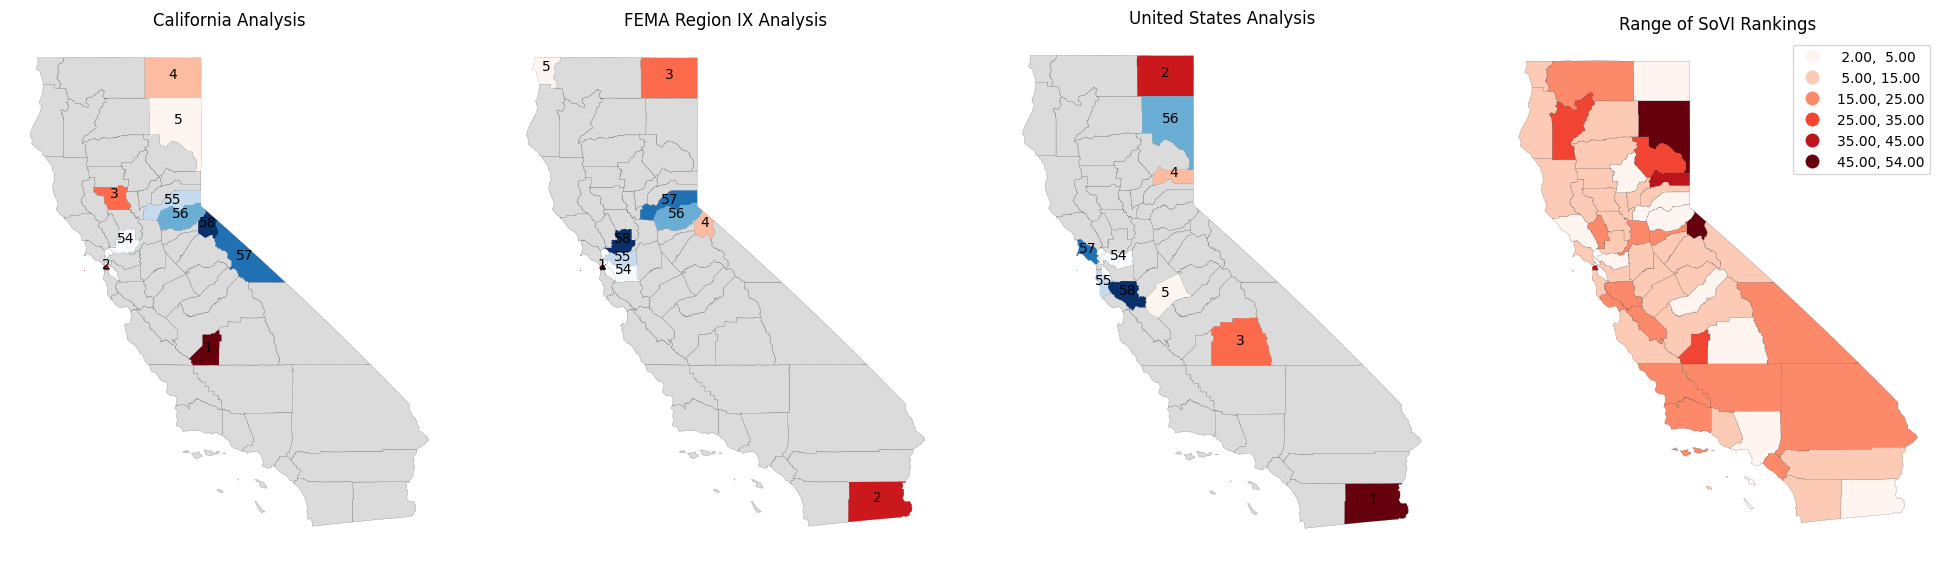

In [17]:
# Create overarching plot
fig, ax = plt.subplots(1, 4, figsize=(20, 8))

fig.tight_layout()

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off');

# Create CA rank map
top5_CA = counties_CA.loc[counties_CA["rank_CA"] < 6]
bottom5_CA = counties_CA.loc[counties_CA["rank_CA"] > 53]
ax[0].set_title("California Analysis")
counties_CA.plot(ax = ax[0], cmap = mycolor, edgecolor = 'black', linewidth = .1)
top5_CA.plot(ax = ax[0], column = "rank_CA", cmap = "Reds_r")
top5_CA.apply(lambda x: ax[0].annotate(text=round(x['rank_CA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );
bottom5_CA.plot(ax = ax[0], column = "rank_CA", cmap = "Blues");
bottom5_CA.apply(lambda x: ax[0].annotate(text=round(x['rank_CA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );

# Create FEMA rank map
top5_CA = counties_CA.loc[counties_CA["rank_FEMA"] < 6]
bottom5_CA = counties_CA.loc[counties_CA["rank_FEMA"] > 53]
ax[1].set_title("FEMA Region IX Analysis")
counties_CA.plot(ax = ax[1], cmap = mycolor, edgecolor = 'black', linewidth = .1)
top5_CA.plot(ax = ax[1], column = "rank_FEMA", cmap = "Reds_r")
top5_CA.apply(lambda x: ax[1].annotate(text=round(x['rank_FEMA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );
bottom5_CA.plot(ax = ax[1], column = "rank_FEMA", cmap = "Blues");
bottom5_CA.apply(lambda x: ax[1].annotate(text=round(x['rank_FEMA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );

# Create USA rank map
top5_CA = counties_CA.loc[counties_CA["rank_USA"] < 6]
bottom5_CA = counties_CA.loc[counties_CA["rank_USA"] > 53]
ax[2].set_title("United States Analysis")
counties_CA.plot(ax = ax[2], cmap = mycolor, edgecolor = 'black', linewidth = .1)
top5_CA.plot(ax = ax[2], column = "rank_USA", cmap = "Reds_r")
top5_CA.apply(lambda x: ax[2].annotate(text=round(x['rank_USA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );
bottom5_CA.plot(ax = ax[2], column = "rank_USA", cmap = "Blues");
bottom5_CA.apply(lambda x: ax[2].annotate(text=round(x['rank_USA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );

# Create range rank map
ax[3].set_title("Range of SoVI Rankings")
counties_CA["min_rank"] = counties_CA[["rank_USA", "rank_FEMA", "rank_CA"]].min(axis = 1)
counties_CA["max_rank"] = counties_CA[["rank_USA", "rank_FEMA", "rank_CA"]].max(axis = 1)
counties_CA["range_rank"] = counties_CA["max_rank"] - counties_CA["min_rank"]
counties_CA.plot(ax = ax[3], column = "range_rank", cmap = "Reds", edgecolor = 'black', linewidth = .1, scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[5,15,25,35,45]));

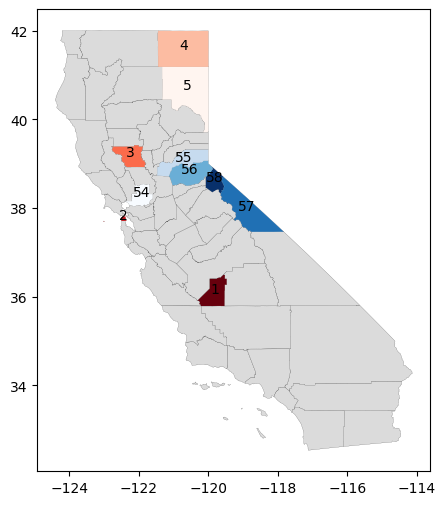

In [18]:
top5_CA = counties_CA.loc[counties_CA["rank_CA"] < 6]
bottom5_CA = counties_CA.loc[counties_CA["rank_CA"] > 53]

fig, ax = plt.subplots(figsize=(6, 6))

counties_CA.plot(ax = ax, cmap = mycolor, edgecolor = 'black', linewidth = .1)
top5_CA.plot(ax = ax, column = "rank_CA", cmap = "Reds_r")
top5_CA.apply(lambda x: ax.annotate(text=round(x['rank_CA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );
bottom5_CA.plot(ax = ax, column = "rank_CA", cmap = "Blues");
bottom5_CA.apply(lambda x: ax.annotate(text=round(x['rank_CA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );

Is 3 in a different place here?

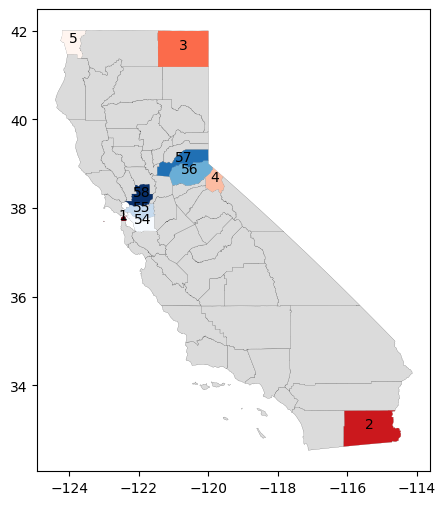

In [19]:
top5_CA = counties_CA.loc[counties_CA["rank_FEMA"] < 6]
bottom5_CA = counties_CA.loc[counties_CA["rank_FEMA"] > 53]

fig, ax = plt.subplots(figsize=(6, 6))

counties_CA.plot(ax = ax, cmap = mycolor, edgecolor = 'black', linewidth = .1)
top5_CA.plot(ax = ax, column = "rank_FEMA", cmap = "Reds_r")
top5_CA.apply(lambda x: ax.annotate(text=round(x['rank_FEMA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );
bottom5_CA.plot(ax = ax, column = "rank_FEMA", cmap = "Blues");
bottom5_CA.apply(lambda x: ax.annotate(text=round(x['rank_FEMA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );

Why did 4 and 5 switch places here?

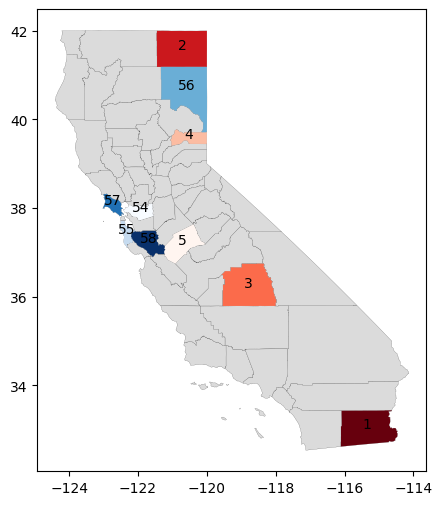

In [20]:
top5_CA = counties_CA.loc[counties_CA["rank_USA"] < 6]
bottom5_CA = counties_CA.loc[counties_CA["rank_USA"] > 53]

fig, ax = plt.subplots(figsize=(6, 6))

counties_CA.plot(ax = ax, cmap = mycolor, edgecolor = 'black', linewidth = .1)
top5_CA.plot(ax = ax, column = "rank_USA", cmap = "Reds_r")
top5_CA.apply(lambda x: ax.annotate(text=round(x['rank_USA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );
bottom5_CA.plot(ax = ax, column = "rank_USA", cmap = "Blues");
bottom5_CA.apply(lambda x: ax.annotate(text=round(x['rank_USA']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1, );

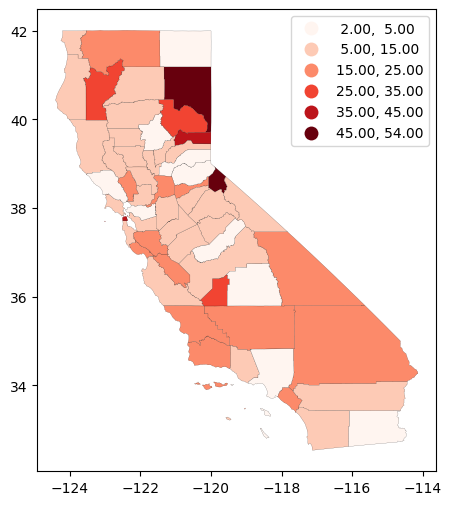

In [21]:
counties_CA["min_rank"] = counties_CA[["rank_USA", "rank_FEMA", "rank_CA"]].min(axis = 1)
counties_CA["max_rank"] = counties_CA[["rank_USA", "rank_FEMA", "rank_CA"]].max(axis = 1)
counties_CA["range_rank"] = counties_CA["max_rank"] - counties_CA["min_rank"]
fig, ax = plt.subplots(figsize=(6, 6))
counties_CA.plot(ax = ax, column = "range_rank", cmap = "Reds", edgecolor = 'black', linewidth = .1, scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[5,15,25,35,45]));

In [22]:
# Construct table to hold the results of the drop one analysis
# Sort variable list based on importance rank.
USvarRanks = rankContrib[["USA"]].copy()  # have to make a copy to sort index ## WHICH FILE IS THIS??????
USvarRanks.sort_values('USA')
dropLevels = USvarRanks.index

In [23]:
counties = pd.read_csv(here(path["ddpub"], "counties.csv"), dtype = {'GEOID': object})

input_names = [['MEDAGE_ACS', 'pos', 'person', 'Median Age'],
               ['BLACK_ACS', 'pos', 'person', 'Pop African-American (%)'],
               ['QNATAM_ACS', 'pos', 'person', 'Pop Native American (%)'],
               ['QASIAN_ACS', 'pos', 'person', 'Pop Asian (%)'],
               ['QHISP_ACS', 'pos', 'person', 'Pop Hispanic (%)'],
               ['QAGEDEP_ACS', 'pos', 'person', 'Age Dependency (%)'],
               ['QPUNIT_ACS', 'pos', 'person', 'Persons Per Housing Unit'],
               ['PRENTER_ACS', 'pos', 'hu', 'Rental Housing (%)'],
               ['QNRRES_ACS', 'pos', 'person', 'Nursing Home Residents (%)'],
               ['QFEMALE_ACS', 'pos', 'person', 'Pop Female (%)'],
               ['QFHH_ACS', 'pos', 'hu', 'Female-Headed Households (%)'],
               ['QUNOCCHU_ACS', 'pos', 'hu', 'Vacant Housing (%)'],
               ['PERCAP_ALT', 'neg', 'person', 'Per-Capita Income'],
               ['QESL_ALT', 'pos', 'person', 'English as Second Language (%)'],
               ['QCVLUN', 'pos', 'person', 'Unemployment (%)'],
               ['QPOVTY', 'pos', 'person', 'Poverty (%)'],
               ['QMOHO', 'pos', 'hu', 'Mobile Homes (%)'],
               ['QED12LES_ALT', 'pos', 'person',
                   'Adults Completed <Grade 12 (%)'],
               ['QFEMLBR', 'pos', 'person', 'Female Employment (%)'],
               ['QEXTRCT_ALT', 'pos', 'person',
                   'Extractive Sector Employment (%)'],
               ['QSERV_ALT', 'pos', 'person', 'Service Sector Employment (%)'],
               ['QSSBEN', 'pos', 'hu', 'Social Security Income (%)'],
               ['QNOAUTO_ALT', 'pos', 'hu', 'No Automobile (%)'],
               ['QFAM', 'neg', 'person', 'Children in Married Families (%)'],
               ['QRICH200K', 'neg', 'hu', 'Annual Income >$200K (%)'],
               ['MDGRENT_ALT', 'neg', 'hu', 'Median Rent'],
               ['MHSEVAL_ALT', 'neg', 'hu', 'Median Home Value'],
               ['POPDENS', 'pos', 'person', 'Population Density']]

# Get attribute names
attr_names = [j[0] for j in input_names] + ['GEOID']

# Select only the columns needed to compute SoVI
counties = counties[attr_names]

# build multindex
geoLevels = counties.GEOID
geoLabels = [] 

In [24]:
for _ in range(len(dropLevels)):
    geoLabels.extend(range(len(geoLevels)))
dropLabels = np.repeat(range(len(dropLevels)), len(geoLevels))


In [25]:

US_Drop1_Multi_Index = pd.MultiIndex(levels=[dropLevels, geoLevels],
                                     labels=[dropLabels, geoLabels],
                                     names=['DroppedVar', 'Geo_FIPS'])

US_Drop1_NetContrib = pd.DataFrame(index=dropLevels, columns=dropLevels)

US_SoVI_Drop1_Score = pd.DataFrame(index=US_Drop1_Multi_Index, columns=['sovi'])

# Compute drop-one
for j in dropLevels:
    US_dropj = US_All.drop([j, 'Geo_FIPS', 'stateID'], axis=1, inplace=False)
    pca = SPSS_PCA(US_dropj, reduce=True, varimax=True)
    sovi_actual = pca.scores_rot.sum(1)
    sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
    US_SoVI_Drop1_Score.loc[j, 'sovi'] = sovi_actual.values
    attrib_contribution = pd.DataFrame(data=pca.weights_rot.sum(1), index=US_dropj.columns)
    # print(j +" " + str(np.isnan(attrib_contribution.values).sum()))
    attrib_contribution = attrib_contribution.transpose()
    attrib_contribution.index = [j]
    # print(attrib_contribution.loc[j,:])
    US_Drop1_NetContrib.loc[j, attrib_contribution.columns] = attrib_contribution.loc[j, :]  # .values

# Sort descriptive labels
USvarRanks = rankContrib.USA.copy()
USvarRanks.index = desc
USvarRanks.sort('USA')
US_Drop1_NetContrib.index = USvarRanks.index
US_Drop1_NetContrib.columns = USvarRanks.index

US_Drop1_NetContrib = US_Drop1_NetContrib.T  # T so columns indexes dropped variable.

# In[ ]:

US_Drop1_NetContrib = US_Drop1_NetContrib.convert_objects(convert_numeric=True)
US_Drop1_NetContrib = US_Drop1_NetContrib.apply(lambda x: np.round(x, 2))

# In[ ]:

get_ipython().magic(u'matplotlib inline')
sns.set_context("poster")

# Reorder and apply variable description to labels
# USvarRanks = rankContrib.USA.copy() #have to make a copy to sort index
# USvar
# dropLevels = USvarRanks.indexdesc

# plt.figure(figsize=(20, 16))
mask = np.isnan(US_Drop1_NetContrib)
sns.heatmap(US_Drop1_NetContrib, annot=True, linewidths=.25, vmin=-1, vmax=1, annot_kws={"size": 7})
# >>>>>>> Stashed changes


TypeError: __new__() got an unexpected keyword argument 'labels'

In [ ]:
?sns.heatmap

Figure 2 Code I don't need anymore

In [ ]:
# Step TC7: adjust signs of USA model to undo pre-PCA alteration
for name, sign, sample, hrname in input_names:
    if sign == 'neg':
        if usa_adj.loc[name] == 'pos':
            usa_adj.loc[name] = 'neg'
        elif usa_adj.loc[name] == 'neg':
            usa_adj.loc[name] == 'pos'
    elif sign == 'pos':
        pass
    else:
        print("problem in flipping signs")
        raise

In [ ]:
reversals = variable_contributions.copy()
for i in range(len(variable_contributions.index)): # Iterate over the variables
    if variable_contributions.index[i] != input_names[i][0]:
        print("ERROR")
        break
    else:
        for j in range(len(variable_contributions.columns)):
            if input_names[i][1] == "pos" and variable_contributions.iloc[i, j] > 0:
                reversals.iloc[i, j] = 0
            elif input_names[i][1] == "neg" and variable_contributions.iloc[i, j] > 0:
                reversals.iloc[i, j] = 1
            elif input_names[i][1] == "neg" and variable_contributions.iloc[i, j] < 0:
                reversals.iloc[i, j] = 0
            elif input_names[i][1] == "pos" and variable_contributions.iloc[i, j] < 0:
                reversals.iloc[i, j] = 1
            else:
                print("WATCH OUT THERE'S A ZERO BRO")